In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sns
from matplotlib import pyplot as plt
import pyGadget

In [2]:
sns.set_context('poster')

In [3]:
sim = pyGadget.sim.Simulation('stampede/vanilla',length='AU')

In [4]:
rad = 1e5
views = {'native':None, 'face (xy)':'face', 'xz':'xz', 'yz':'yz'}
particles = {'x':[], 'y':[], 'z':[], 'n':[], 'view':[], 'snapshot':[]}
for snap in [355,1900]:# 400, 500, 615, 800, 1000, 1200, 1500, 1700, 1900]:
    s = sim.load_snapshot(snap)
    s.gas.load_coords()
    for v in ['native', 'face (xy)', 'xz', 'yz']:
        vv = views[v]
        s.gas.orient_box(centering='max', view=vv)
        r2d = np.linalg.norm(s.gas.coordinates[:,:2], axis=1)
        pos, n = pyGadget.analyze.data_slice(r2d < rad, s.gas.coordinates, s.gas.ndensity)
        particles['x'].extend(pos[:,0])
        particles['y'].extend(pos[:,1])
        particles['z'].extend(pos[:,2])
        particles['n'].extend(n)
        particles['view'].extend([v for i in range(n.size)])
        particles['snapshot'].extend([snap for i in range(n.size)])

    s.gas.cleanup()
    s.close()

Turning on gas particle refinement.
There are 8000000 highest resolution particles.
Density maximum box center: 5.694e+08 5.686e+08 5.615e+08
Density maximum box center: 4.240e-01 -1.249e-01 -1.085e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Turning on gas particle refinement.
There are 7997231 highest resolution particles.
Density maximum box center: 5.695e+08 5.687e+08 5.615e+08
Density maximum box center: 1.526e+00 2.301e+00 -1.088e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum b

In [5]:
particles = pd.DataFrame(particles)
particles['log z'] = np.log10(particles['z'])
particles['log n'] = np.log10(particles['n'])

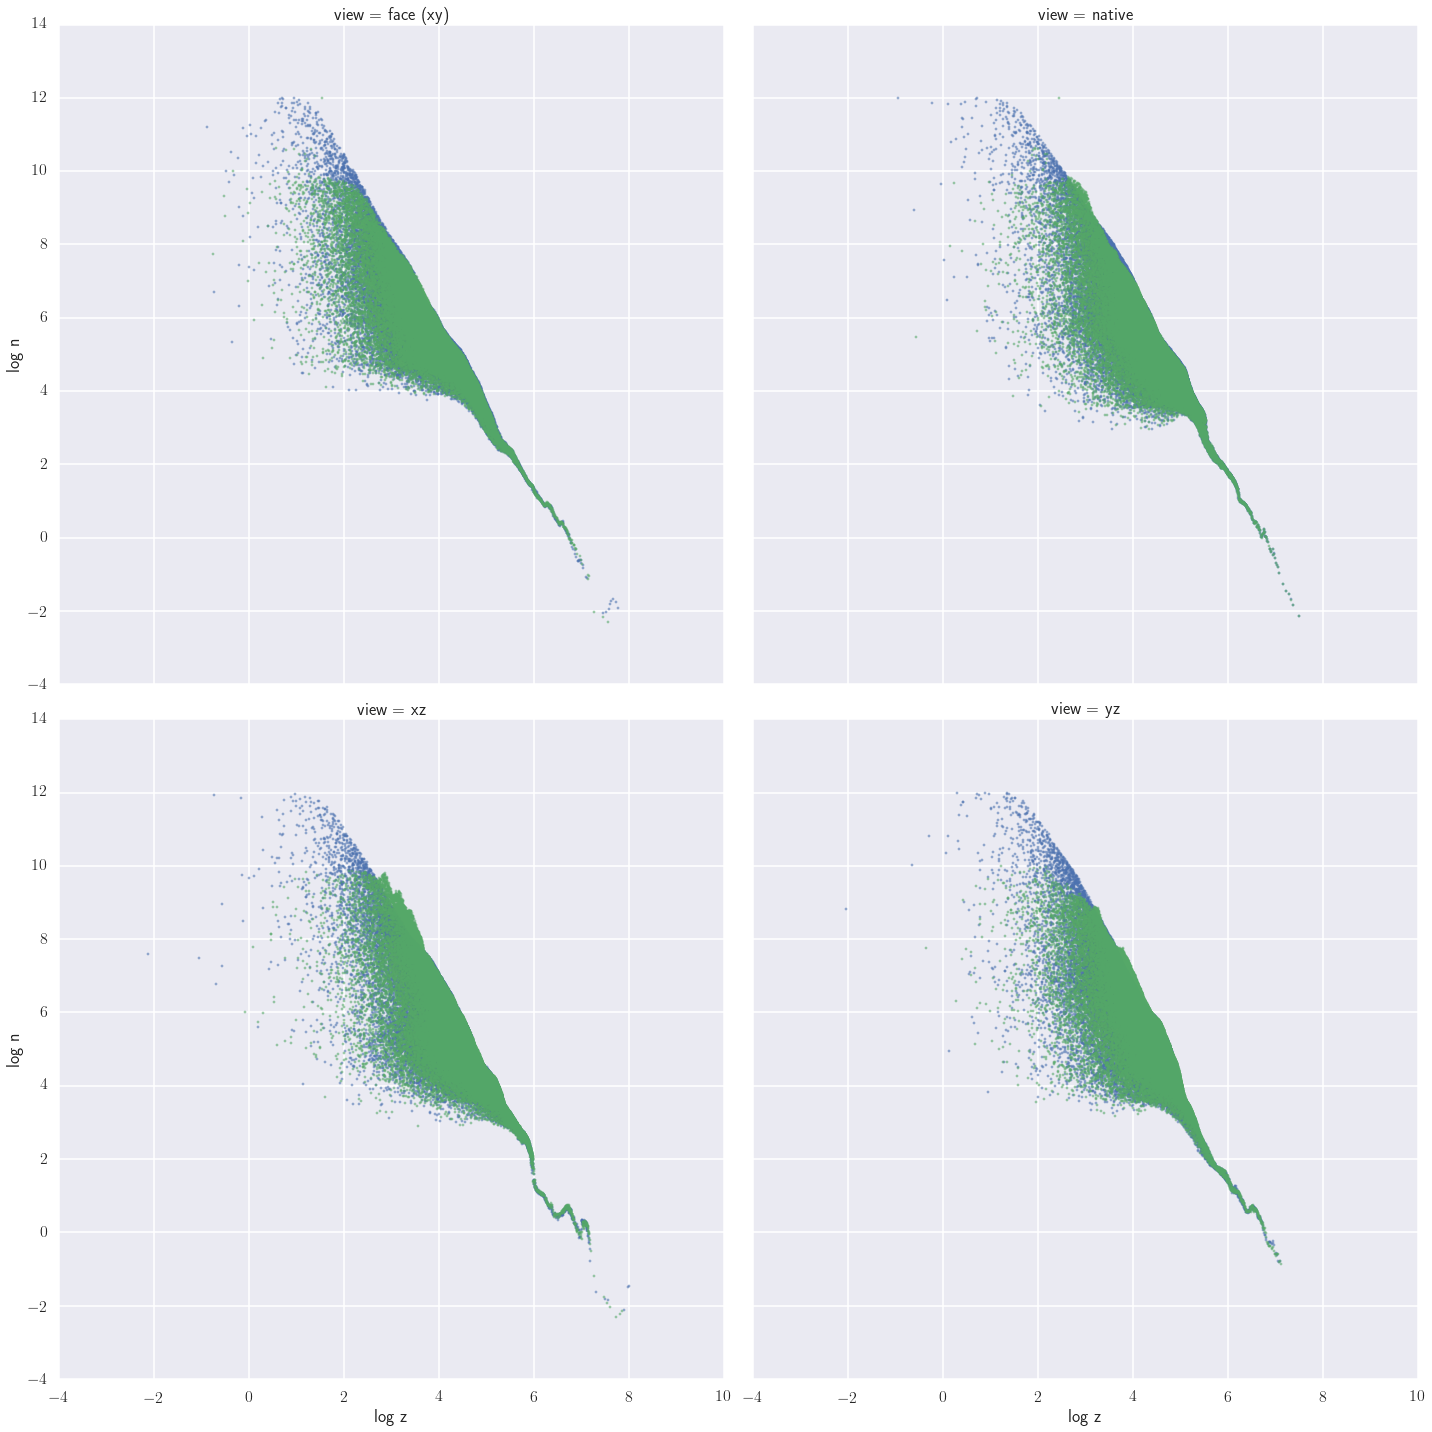

In [6]:
g = sns.FacetGrid(particles, col='view', hue='snapshot', col_wrap=2, size=10)
g.map(plt.scatter, 'log z', 'log n', s=5, alpha=.5)#, linewidth=.5, edgecolor="white")

In [7]:
g.fig.savefig('figures/optical_depth/views-overlay.png', bbox_inches='tight')

# Interpolating Column with griddata

In [8]:
xmax = ymax = 1
xmin = ymin = -1
zmax = 1e7
zmin = 0
(zmax-zmin)

10000000.0

In [9]:
grid_x, grid_y, grid_z = np.mgrid[xmin:xmax:3j, ymin:ymax:3j, zmin:zmax:10000001j]

In [10]:
grid_z.shape, grid_z.size

((3, 3, 10000001), 90000009)

In [11]:
z = grid_z[1,1]
z[1] - z[0] #Double-check grid spacing!

1.0

In [12]:
sigma = 1.14e-23
optical_depth = {'z':[], 'n':[], 'N':[], 'tau':[], 'view':[], 'snapshot':[]}
for snap in [355,1900]:# 400, 500, 615, 800, 1000, 1200, 1500, 1700, 1900]:
    for view in ['native', 'face (xy)', 'xz', 'yz']:
        selection = particles[(particles['view'] == view) & (particles['snapshot'] == snap)]
        pos = np.column_stack([selection['x'].values, selection['y'].values, selection['z'].values])
        n = selection['n'].values
        grid_n = griddata(pos, n, (grid_x, grid_y, grid_z), method='linear')
        nz = grid_n[1,1]
        N = nz[::-1].cumsum() * 1.49597871e13 #convert from AU to cm
        tau = N[::-1] * sigma
        print snap, view, tau[0]
        optical_depth['z'].extend(z)
        optical_depth['n'].extend(nz)
        optical_depth['N'].extend(N[::-1])
        optical_depth['tau'].extend(tau)
        optical_depth['view'].extend([view for i in range(z.size)])
        optical_depth['snapshot'].extend([snap for i in range(z.size)])
optical_depth = pd.DataFrame(optical_depth)

355 native 8793.8607076
355 face (xy) 5626.76440626
355 xz 8266.0045326
355 yz 11596.0033682
1900 native 14814.2869246
1900 face (xy) 5395.0164698
1900 xz 15807.7833246
1900 yz 12321.7338115


In [13]:
store = pd.HDFStore("/home/r900-4/jhummel/data/simdata/xrays/optical_depth_analysis.hdf5")

In [14]:
store['particles'] = particles
store['optical_depth'] = optical_depth

In [15]:
store.close()

In [16]:
optical_depth[optical_depth['z'] == 0]

,N,n,snapshot,tau,view,z
0,7.713913e+26,1.038198e+12,355,8793.860708,native,0
10000001,4.935758e+26,1.038198e+12,355,5626.764406,face (xy),0
20000002,7.250881e+26,1.038198e+12,355,8266.004533,xz,0
30000003,1.017193e+27,1.038198e+12,355,11596.003368,yz,0
40000004,1.299499e+27,1.000000e+12,1900,14814.286925,native,0
50000005,4.732471e+26,1.000000e+12,1900,5395.016470,face (xy),0
60000006,1.386648e+27,1.000000e+12,1900,15807.783325,xz,0
70000007,1.080854e+27,1.000000e+12,1900,12321.733811,yz,0


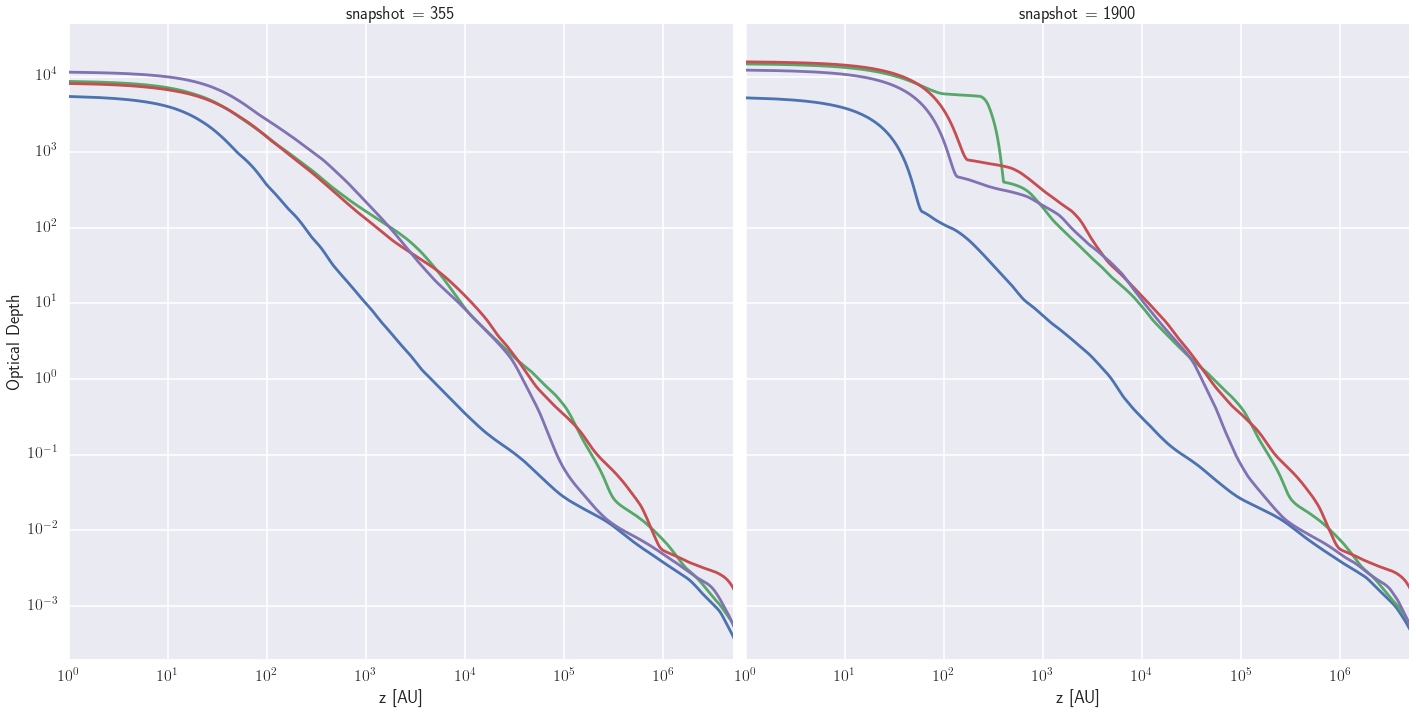

In [17]:
g = sns.FacetGrid(optical_depth, col='snapshot', hue='view', col_wrap=2, size=10)
g.map(plt.loglog, 'z', 'tau')
g.set(xlim=(1,5e6), ylim=(2e-4, 5e4))
g.set_xlabels('z [AU]')
g.set_ylabels('Optical Depth')
g.fig.subplots_adjust(wspace=.02)

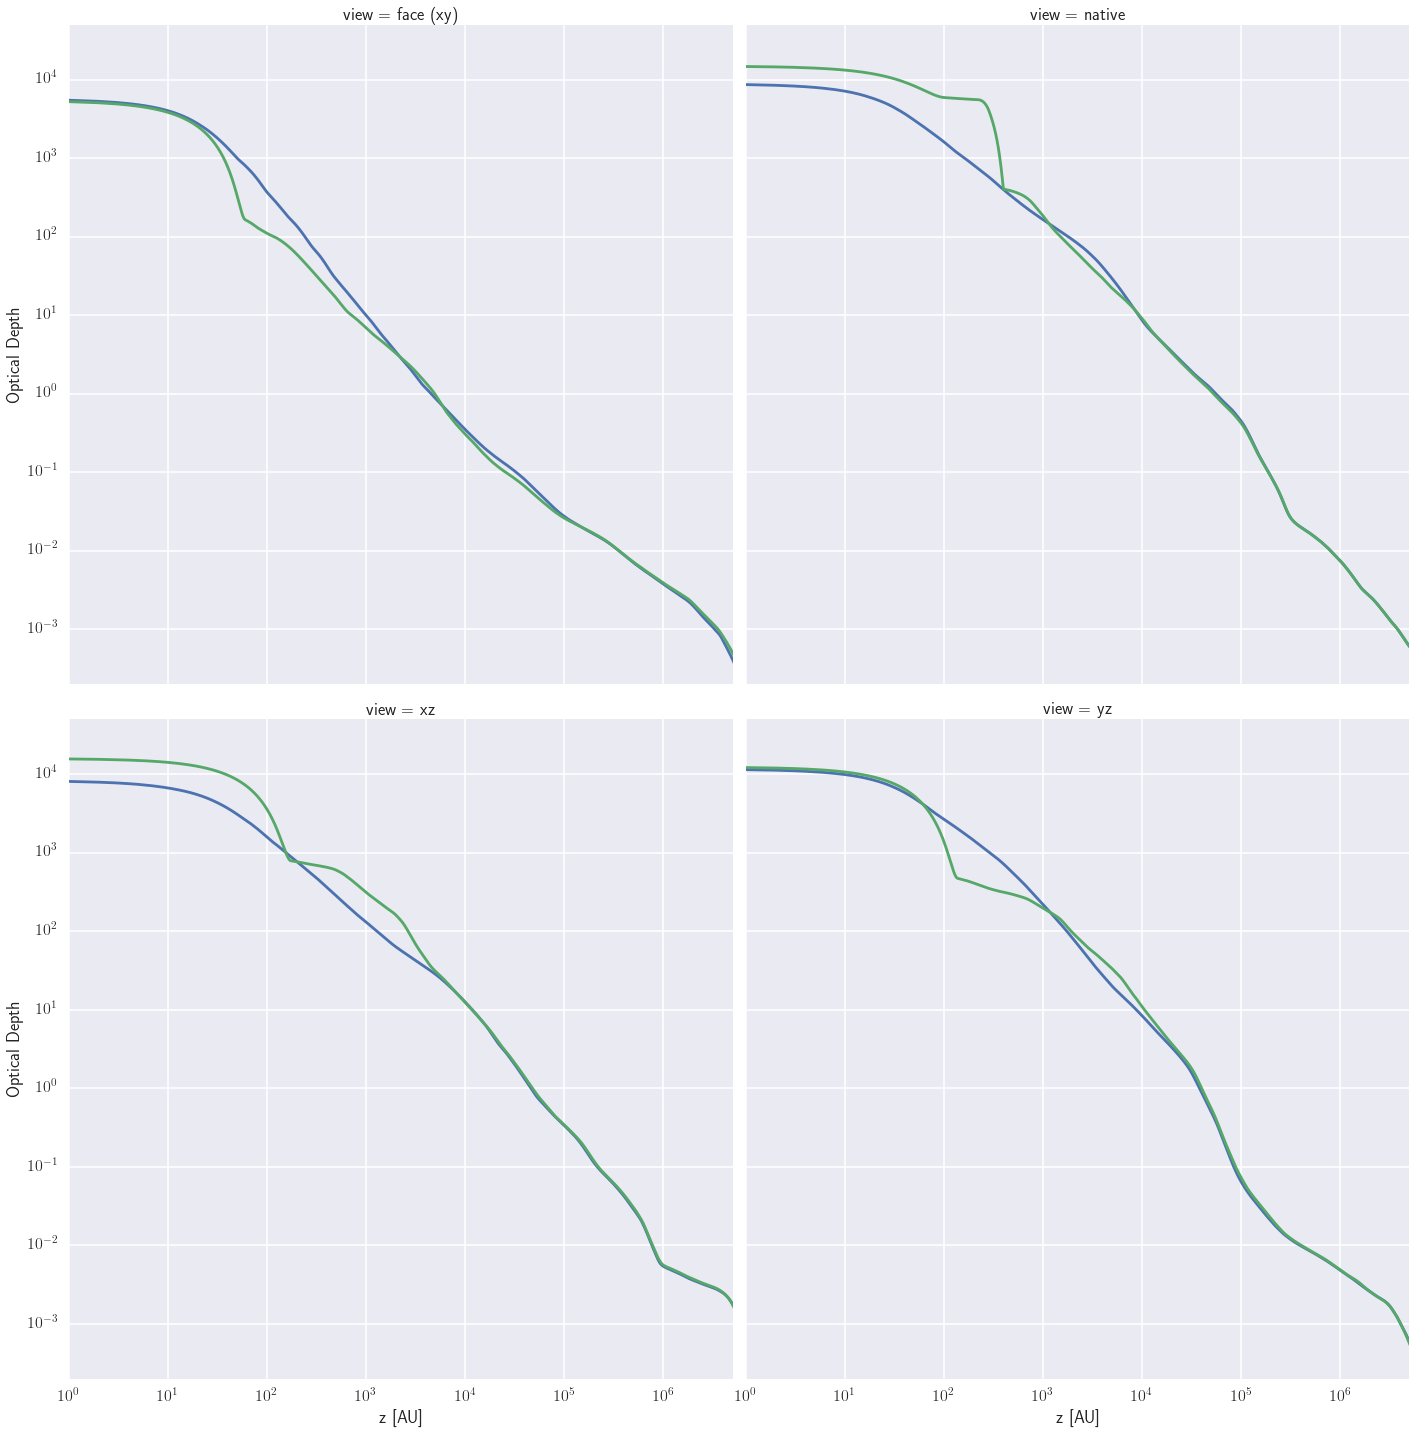

In [18]:
g = sns.FacetGrid(optical_depth, col='view', hue='snapshot', col_wrap=2, size=10)
g.map(plt.loglog, 'z', 'tau')
g.set(xlim=(1,5e6), ylim=(2e-4, 5e4))
g.set_xlabels('z [AU]')
g.set_ylabels('Optical Depth')
g.fig.subplots_adjust(wspace=.02)

In [19]:
g.fig.savefig('figures/optical_depth/optical_depth-r.png', bbox_inches='tight')

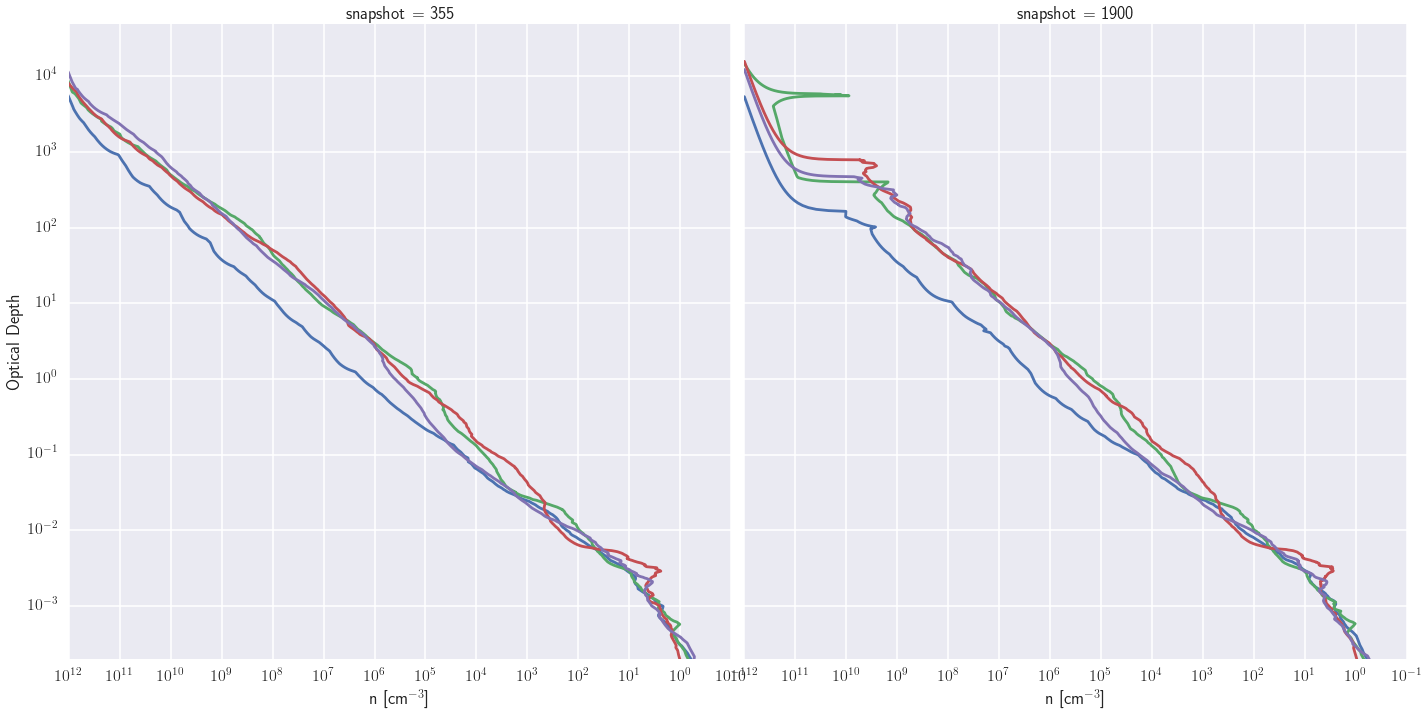

In [20]:
g = sns.FacetGrid(optical_depth, col='snapshot', hue='view', col_wrap=2, size=10)
g.map(plt.loglog, 'n', 'tau')
g.set(xlim=(1e12,.1), ylim=(2e-4, 5e4))
g.set_xlabels('n [cm$^{-3}$]')
g.set_ylabels('Optical Depth')
g.fig.subplots_adjust(wspace=.02)

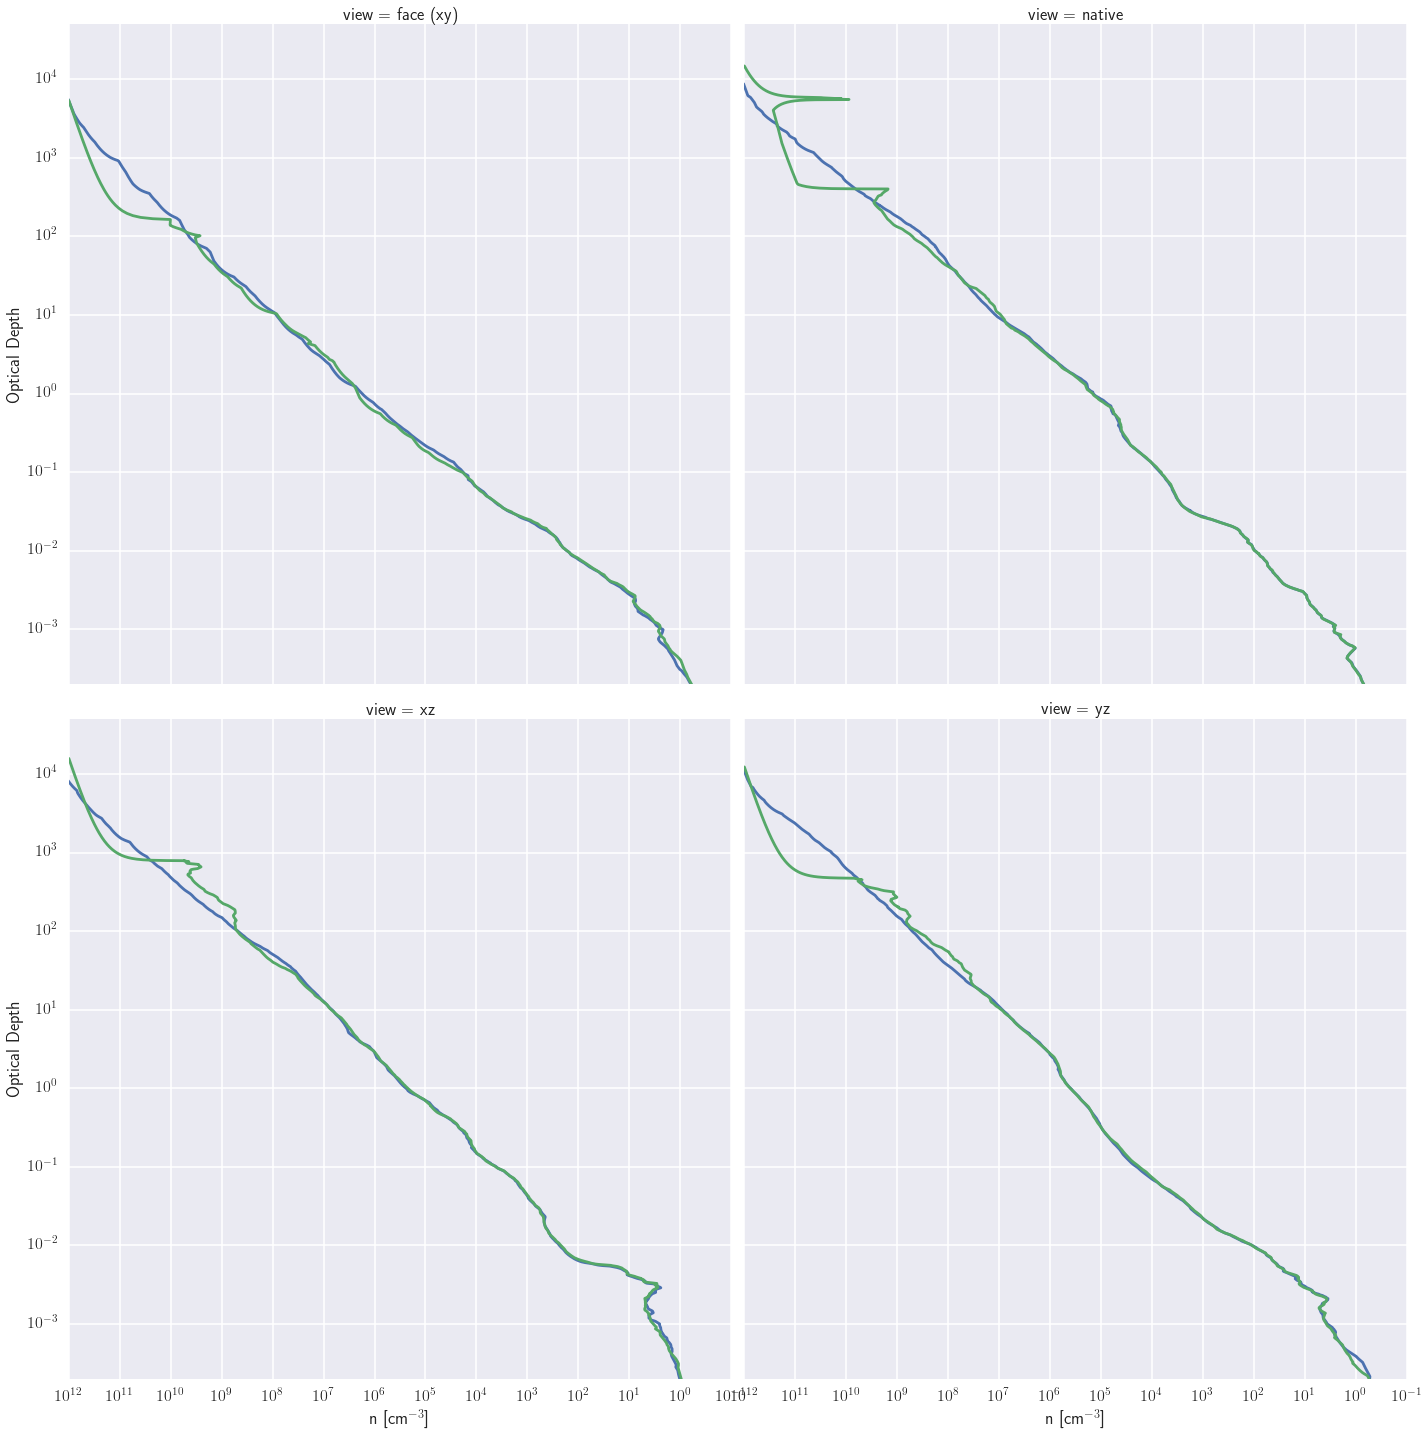

In [21]:
g = sns.FacetGrid(optical_depth, col='view', hue='snapshot', col_wrap=2, size=10)
g.map(plt.loglog, 'n', 'tau')
g.set(xlim=(1e12,.1), ylim=(2e-4, 5e4))
g.set_xlabels('n [cm$^{-3}$]')
g.set_ylabels('Optical Depth')
g.fig.subplots_adjust(wspace=.02)

In [22]:
g.fig.savefig('figures/optical_depth/optical_depth-n.png', bbox_inches='tight')